In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import astropy as asp
from astropy.table import hstack, vstack
import pickle
import tqdm

In [2]:
with open(f'/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff_2_11/run_700907_12/ECDFS_sim_im.pkl', "rb") as f:
    afw_dic = pickle.load(f)
with open(f'/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff_2_11/run_700907_12/ECDFS_sim_truth.pkl', "rb") as f:
    true_cats = pickle.load(f)
with open(f'/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff_2_11/run_700907_12/ECDFS_sim_meas_forced_s.pkl', "rb") as f:
    full_cats_s = pickle.load(f)

In [3]:
area = (900 * 0.2 /60)**2

In [4]:
from matplotlib.patches import Ellipse
from astropy.visualization import ImageNormalize, AsinhStretch, PercentileInterval

def make_some_plots(afw_img, cat, truth, area):

    cat = cat[(cat['deblend_nChild'] == 0) &
              (cat['base_SdssShape_flag'] == False) &
              (cat['modelfit_CModel_instFlux_i'] >= 0) &
              (cat['modelfit_CModel_flag_i'] == False) &
              (cat['base_SdssCentroid_flag'] == False) &
              (cat['in_img'] == True)]
    snr = (cat['base_PsfFlux_instFlux_i']/cat['base_PsfFlux_instFluxErr_i'] >= 10)
    mag = -2.5 * np.log10(cat['modelfit_CModel_instFlux_i']) + 31.4
    tmag = -2.5 * np.log10(truth['i']['flux']) + 31.4

    mag_lim = np.percentile(mag, 95) + 1 
    t_mcut = (tmag) < mag_lim

    mag_in = mag[snr& (cat['in_img'] == True)]
    tmag_in = tmag[t_mcut & (truth['i']['in_img'] == True)]
    cat = cat[snr&(cat['in_img'] == True)]
    truth_i = truth['i'][t_mcut & (truth['i']['in_img'] == True)]

    mag_bins = np.linspace(14, 28, 50)
    bin_size = mag_bins[1] - mag_bins[0]

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    mag_weight = np.full_like(mag_in, 1/(area *bin_size))
    tmag_weight = np.full_like(tmag_in, 1/(area *bin_size))

    # ax[0].hist(dp1_m, dp1_b,weights=dp1_w,histtype="step",linewidth=2, label="Dp1")
    ax[0].hist(tmag_in, mag_bins,weights=tmag_weight,histtype="step",linewidth=2,label="Coadd Sim Truth")
    ax[0].hist(mag_in, mag_bins,weights=mag_weight,histtype="step",linewidth=2,label="Coadd Sim")

    ax[0].set_xlabel("Magnitude")
    ax[0].set_ylabel("Number Density (arcmin$^{-2}$ mag$^{-1}$)")
    
    ax[0].set_xlim(14,27)
    ax[0].set_yscale('log')

    norm = ImageNormalize(
        afw_img['afw_image'].image.array,
        interval=PercentileInterval(99.5),  # clip extremes
        stretch=AsinhStretch())
    ax[1].imshow(afw_img['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
    ax[1].set_xlim(25,925)
    ax[1].set_ylim(25,925)
    for i in range(len(cat)):
        x = cat['base_SdssCentroid_x'][i]
        y = cat['base_SdssCentroid_y'][i]
        xx = cat['base_SdssShape_xx'][i]
        yy = cat['base_SdssShape_yy'][i]
        xy = cat['base_SdssShape_xy'][i]

        T = 0.5 * (xx + yy)
        D = np.sqrt(((xx - yy) / 2)**2 + xy**2)
        a = np.sqrt(T + D)
        b = np.sqrt(T - D)
        theta = 0.5 * np.arctan2(2 * xy, xx - yy)
        
        e = Ellipse((x, y), width=2*a, height=2*b,
                    angle=np.degrees(theta), edgecolor='red',
                    facecolor='none', lw=0.8)
        ax[1].add_patch(e)

    for i in range(len(truth_i)):
        x = truth_i['x'][i]
        y = truth_i['y'][i]

        e = Ellipse((x, y), width=2, height=2,
                    angle=np.degrees(theta), edgecolor='green',
                    facecolor='none', lw=0.8)
        ax[1].add_patch(e)

    ax[1].set_xlabel('x [pixels]')
    ax[1].set_ylabel('y [pixels]')
    ax[0].set_title('i image')
    ax[0].legend()
    plt.show()

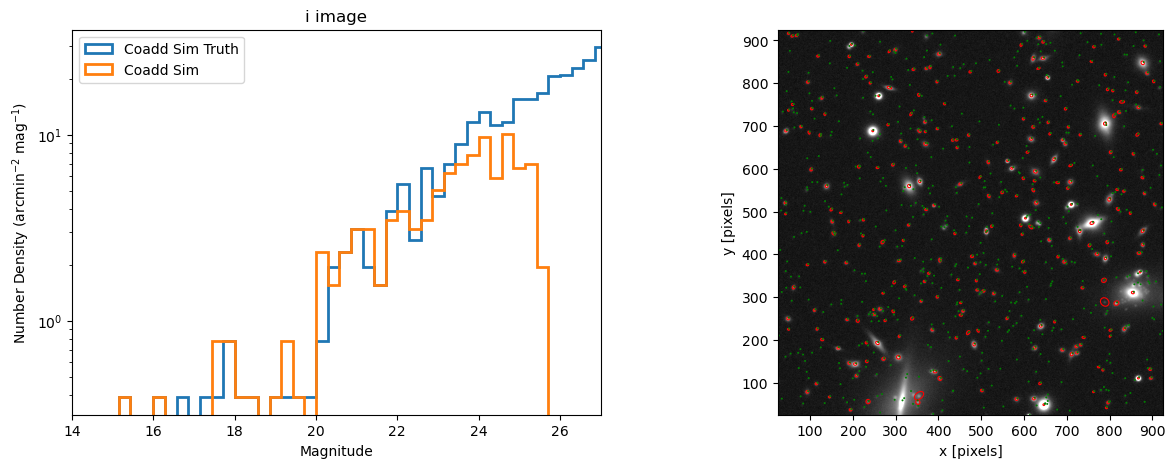

In [5]:
make_some_plots(afw_dic['i'], full_cats_s, true_cats, area)

0.933852140077821
-0.03960926171710376
0.20781769227704422


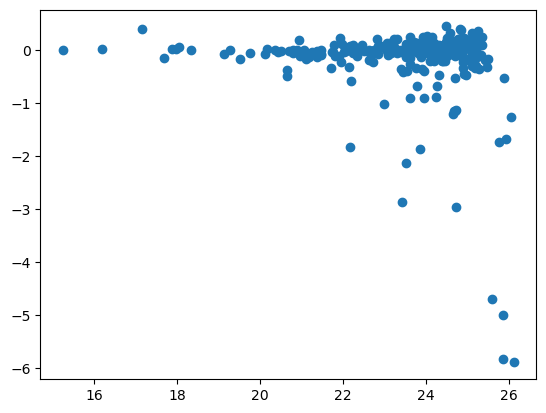

In [6]:
cat = full_cats_s[(full_cats_s['deblend_nChild'] == 0) &
              (full_cats_s['base_SdssShape_flag'] == False) &
              (full_cats_s['modelfit_CModel_instFlux_i'] >= 0) &
              (full_cats_s['modelfit_CModel_flag_i'] == False) &
              (full_cats_s['base_SdssCentroid_flag'] == False)&
              (full_cats_s['base_PsfFlux_instFlux_i']/full_cats_s['base_PsfFlux_instFluxErr_i'] >= 10)&
              (full_cats_s['in_img'] == True)]

mag = -2.5*np.log10(cat['modelfit_CModel_instFlux_i']) + 31.4
tmag = -2.5*np.log10(cat['match_flux_i']) + 31.4

diff = mag - tmag

plt.scatter(tmag, diff)
print(np.sum((diff > -1) & (diff < 1))/len(diff))
print(np.mean(diff[(diff > -1) & (diff < 1)]))
print(np.std(diff[(diff > -1) & (diff < 1)]))
plt.show()

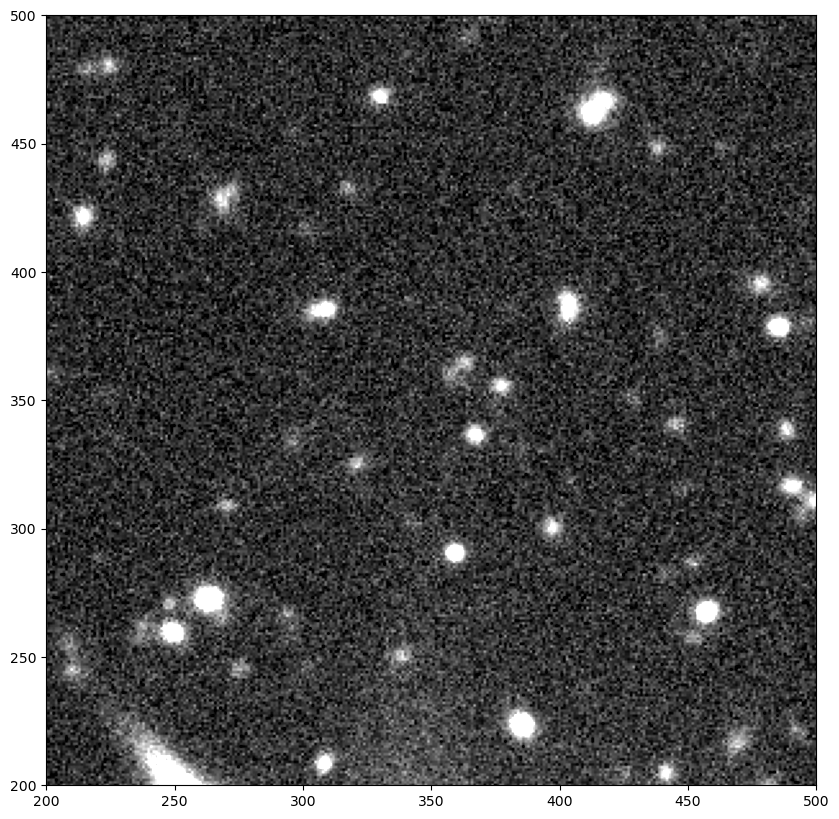

In [11]:
norm = ImageNormalize(
        afw_dic['i']['afw_image'].image.array,
        interval=PercentileInterval(99.5),  # clip extremes
        stretch=AsinhStretch())
fig = plt.figure(figsize=(10,10))
# plt.imshow(afw_dic['i']['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
plt.imshow(afw_dic['i']['afw_image'].image.array, vmin=-3,vmax=15, origin='lower', cmap='gray')
# plt.xlim(25,925)
# plt.ylim(25,925)
plt.xlim(200,500)
plt.ylim(200,500)
plt.show()